In [1]:
%pip install numpy matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def f(x):
    return 3*x**2 - 4*x + 5

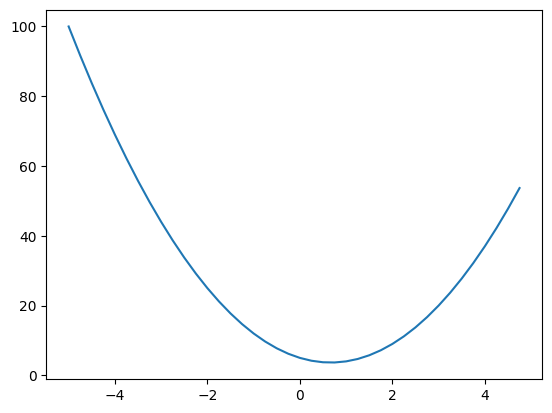

In [24]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [27]:
h = 0.000001

# inputs
a = 2.0
b = -3.0
c = 10.0

d = a*b + c

# what is derivative of d, wrt a, b and c
d1 = a*b + c
d2 = (a+h)*b + c
(d2 - d1)/h

-3.000000000419334

In [28]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # maintains derivative of some output wrt this value
        self._backward = lambda: None # default do nothing (example: leaf nodes)
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    # inbuilt method for printing the object
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    # inbuilt method for `+` operator
    def __add__(self, other):
        other = Value.__wrapValueIfNeeded(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        # lambda to propagate the gradient backward from output to inputs
        # always multiple result by out.grad per chain rule
        # Why += rather than just = ???
            # This is because objects can be reused. Ex: b = a + a, in this case, self and other are the same, so using += will accumulate the gradients. And give gradient of `a` to be 2 
        def _backward(): 
            self.grad += (1.0 * out.grad)
            other.grad += (1.0 * out.grad)
        
        # Important: calling backward pass on the output, sets gradients for the inputs
        out._backward = _backward
        
        return out

    # inbuilt method for `*` operator
    def __mul__(self, other):
        other = Value.__wrapValueIfNeeded(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward(): 
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    # inbuilt method for `**` operator (exponentiation)
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        # d(x^n)/dx == n * x^(n-1)
        def _backward(): 
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out


    # a / b == a * (1/b) == a * b^-1
    def __truediv__(self, other):
        return self * other**-1


    # -self
    def __neg__(self):
        return self * -1


    # self - other == self + (-other)
    def __sub__(self, other):
        return self + (-other)

    
    def tanh(self):
        t = np.tanh(self.data)
        # x = self.data
        # t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1) # np provides this
        out = Value(t, (self, ), 'tanh')

        # d(tanh x)/dx == 1 - tanh^2(x)
        def _backward(): 
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward(): 
            self.grad += math.exp(x) * out.grad
        out._backward = _backward

        return out

    
    # scenario for other + self (example: handling 2 + a)
    def __radd__(self, other):
        return self + other    
    def __rmul__(self, other):
        return self * other

    
    # below allows for simpler notations such as (a+1)
    # where we don't care about labeling these scalars
    @staticmethod
    def __wrapValueIfNeeded(other):
        return other if isinstance(other, Value) else Value(other)

    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) # when coming out of dfs, append to topo
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [39]:
%pip install graphviz
# brew install graphviz


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [38]:
from graphviz import Digraph

def trace(root):
        # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left ot right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

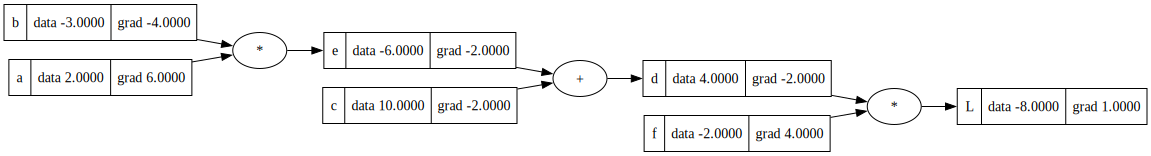

In [45]:
# temp
# L = ((a*b)+c)*f

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'
# draw_dot(L)

L.grad = 1 # derivative of L wrt L is 1
d.grad = -2
f.grad = 4
c.grad = -2
e.grad = -2
b.grad = -4
a.grad = 6

draw_dot(L)

# if we want to push L value up, nudge all value objects in the direction of the gradient
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

# we expect L value to go up. It went from -8 to -7.28
L.data

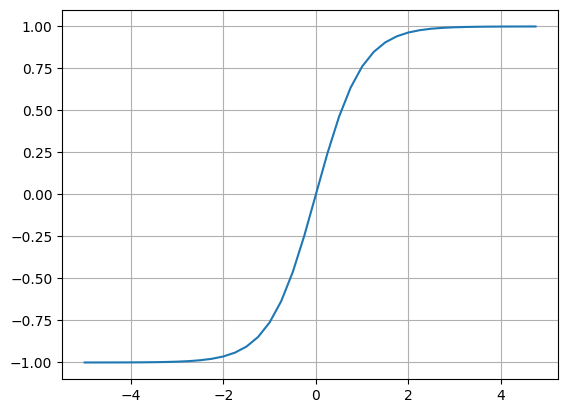

In [47]:
# tanh as an example of a squashification function
xs = np.arange(-5,5,0.25)
ys = np.tanh(xs)
plt.grid()
plt.plot(xs,ys)

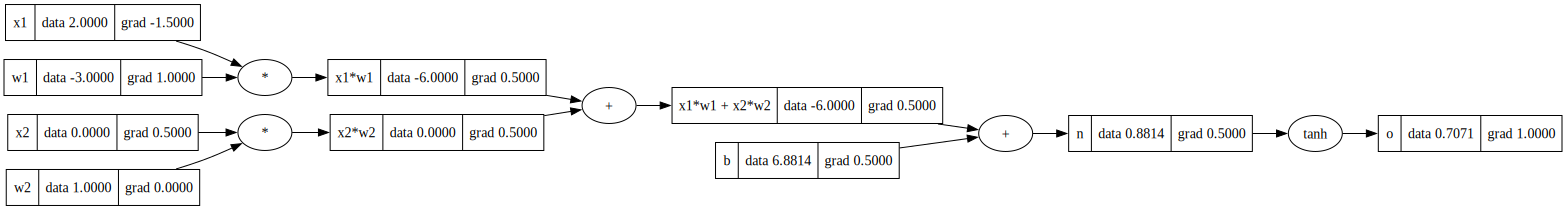

In [71]:
# below example is for a single cell (neuron) with two inputs

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# output = SquishificationFn(x1w1 + x2w2 + b)
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

# compute gradients manually for above
# o.grad = 1.0
# n.grad = 0.5 # 1 - (tanh(n))^2 == 1-o^2 == 1 - 0.5
# b.grad = 0.5 # do/db == do/dn * dn/db == 0.5 * d/db(b + x1w1 + x2w2) == 0.5
# x1w1x2w2.grad = 0.5 # similarly
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# 
# x2.grad = 0.5 # do/dx2 == do/dx2w2 * dx2w2/dx2 == 0.5 * w2 == 0.5
# w2.grad = 0
# x1.grad = -1.5
# w1.grad = 1

# compute gradients automatically for above
# o.grad = 1.0
# o._backward()
# n._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()

# compute gradients more automated for above using topological sort
o.backward()

draw_dot(o)

In [ ]:
# Bug
a = Value(3.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

# db/da == d(a + a)/da == 2
# issue exists every time we use a variable more than once
# solution exists in multivariable case of the chain rule
# an easy way to think of it is that backpropagation should accumulate the gradients

In [72]:
# previous example, with tanh manually computed using (e^(2x) - 1) / (e^(2x) + 1)

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()

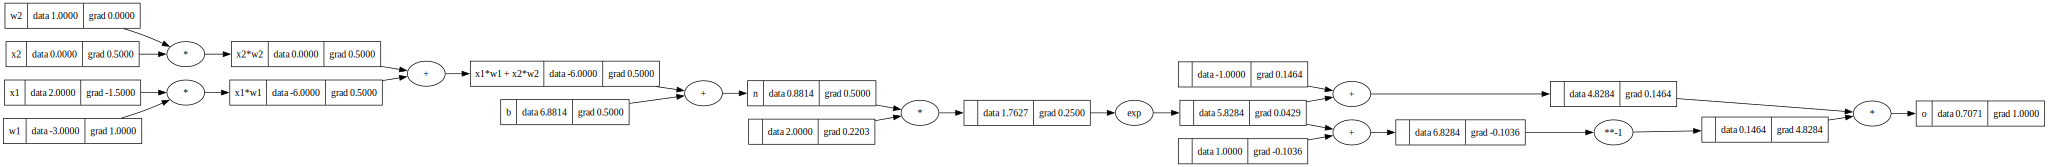

In [74]:
draw_dot(o)

In [75]:
%pip install torch torchvision torchaudio

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/25/07/3548a7cfcf69d0eccec2ee79ee3913f1cdaadb27b36946774db86729ee47/torch-2.5.1-cp39-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/a1/14/c13e8b49fa812266e3340969b3157b11928a3608faa3a0448b8a564b01b8/torchvision-0.20.1-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/13/a0/43a7b3bd4f19bb2ca46e44aee83cba6cb1450f3126d9615f30ac51db24ec/torchaudio-2.5.1-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/b9/f8/feced7779d755758a52d1f6635d990b8d98dc0a29fa568bbe0625f18fdf3/filelock-3.16.1-py3-none-any.whl.metadata
  Obtaining dependency information for networkx from https://files.pythonhosted.org/packages/d5/f0/8fbc882ca80cf077f1b246c0e3c3465f7f415439bdea6b

In [82]:
# previous example using pytorch
# micrograd uses scalar values, pytorch uses tensors (which are just n-dimensional scalars)

import torch

# default is to use float32, using double so we have float64
# by default pytorch assumes that leaf nodes do not require gradients (for efficiency reasons)
# since leaf nodes are usually inputs that we don't need to tune.
# So, we are explicitly mentioning that below.
x1 = torch.Tensor([2.0]).double()                    ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                    ; x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()                   ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                    ; w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()      ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) # .data.item() plucks the scalar value out 
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [83]:
import random

class Neuron:
    def __init__(self, nin):  # nin: number of inputs
        assert isinstance(nin, (int)), "neuron size needs to be of int type"
        # nin is the number of inputs to the neuron
        # initialize nin weights and 1 bias, following uniform distribution between -1 and 1
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # x is an array of nin length
        # return Σw_i*x_i + b
        # zip creates a new iterator that iterates over the touples
        # minor efficiency gain to specify starting sum from a value of self.b below
        act = sum((wi*xi for wi, xi in zip(self.w, x)), start=self.b)
        out = act.tanh()
        return out

    # returns weights and bias value objects 
    def parameters(self):
        return self.w + [self.b]


class Layer:

    def __init__(self, nin, nout):
        # nin is number of inputs to each neuron in this layer
        # nout is number of outputs of the layer (number of neurons in this layer)
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        # treat single output as a special case output layer
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:

    def __init__(self, nin, nouts):  # eg: 4, [5,6]  for 4 inputs, 2 layers of 5,6 neurons respectively
        # nin is number of inputs to each neuron in the 1st (hidden) layer, defines the number of neurons in layer 1
        # nouts is a list of number of neurons in each layer (other than input layer)
        sizes = [nin] + nouts # prepend nin to nout list
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        # call each layer sequentially with output of a layer as input
        # to the next
        for layer in self.layers:
            x = layer(x)
        return x

    # returns all tunable value objects (weights & biases)
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [91]:
## Initializes the Network

# 3 inputs ...
# 2 hidden layers of 4 neurons each neurons
# an output layer with 1 neuron
# total of 41 parameters (weights + biases) == (3*4 + 4) + (4*4 + 4) + (4*1 + 1)

n = MLP(3, [4,4,1])
x = [2.0, 3.0, -1.0]
n(x)

Value(data=-0.6748774540693142, grad=0.0)

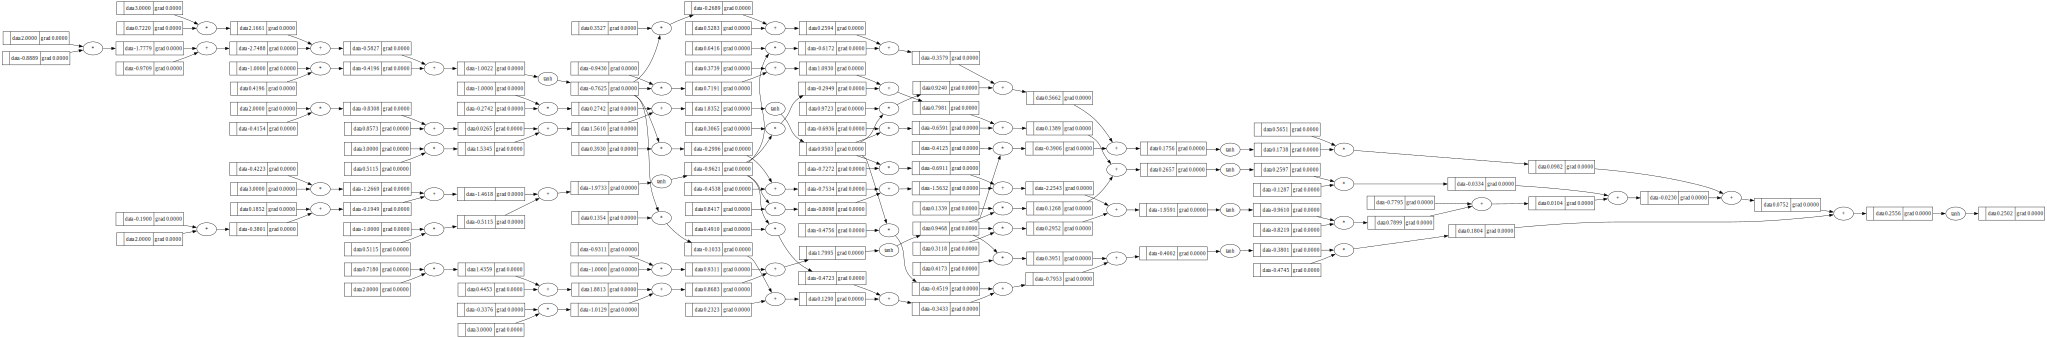

In [86]:
# super complicated now
draw_dot(n(x))

In [87]:
# 4 sets of inputs and 4 outputs (training data for a binary classifier NN, where output is 1 or -1)
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [93]:
# optimizer loop
for k in range(100):
    
    # Forward Pass
    # Compute outputs for training data, and current weights
    ypred = [n(x) for x in xs]
    
    # how do we get predictions to get closer to targets ?
    # we do this by first measuring how bad current output is... aka Loss
    # loss is a Value object created from all outputs of the MLP, from all training data
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # note: ygt is y ground truth (from ys in training set)

    # Backward Pass
    # Run backpropagation algorithm
    # zero_grad
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # Update Parameters
    # nudge each parameter in the opposite direction of the gradient, to minimize loss function
    for p in n.parameters():
        # we noticed through trial and error that -0.01 was too slow and -0.1 was a bit unstable, so trying something in-between
        p.data += -0.05 * p.grad 

    print('Step ', k + 1, '; ', 'Loss ', loss.data)
    #print('Outputs: ', ypred)
    #print('Example w: ', n.layers[0].neurons[0].w)

# this is even more complex cause it has 4 forward passes (one for each training set)
# draw_dot(loss)
    
# if gradient of a specific neuron is negative
# => influence on loss is also negative
# => increasing this a bit will decrease loss a bit

Step  1 ;  Loss  3.0395516209132527
Step  2 ;  Loss  1.8542965045743283
Step  3 ;  Loss  1.3098592513315759
Step  4 ;  Loss  0.8621967620241675
Step  5 ;  Loss  0.5644882060350187
Step  6 ;  Loss  0.3979316146141196
Step  7 ;  Loss  0.3018913818521792
Step  8 ;  Loss  0.24160832085338368
Step  9 ;  Loss  0.20079229170217244
Step  10 ;  Loss  0.17148653599742913
Step  11 ;  Loss  0.1494798354722342
Step  12 ;  Loss  0.1323697050153311
Step  13 ;  Loss  0.11869593608573903
Step  14 ;  Loss  0.10752338467400788
Step  15 ;  Loss  0.0982267103593232
Step  16 ;  Loss  0.09037239659697575
Step  17 ;  Loss  0.08365064545053934
Step  18 ;  Loss  0.07783427461785115
Step  19 ;  Loss  0.07275294233696647
Step  20 ;  Loss  0.06827643876708195
Step  21 ;  Loss  0.06430353647035339
Step  22 ;  Loss  0.06075435875186001
Step  23 ;  Loss  0.05756503707713908
Step  24 ;  Loss  0.05468389535499976
Step  25 ;  Loss  0.052068675464097554
Step  26 ;  Loss  0.049684487109257505
Step  27 ;  Loss  0.047502270

In [171]:
# Demo (from code in repo)

#from micrograd.engine import Value
#from micrograd.nn import Neuron, Layer, MLP

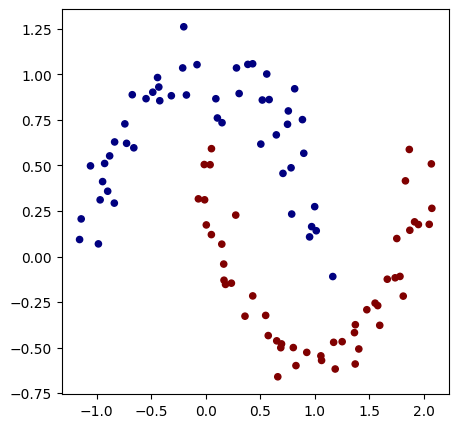

In [487]:
# make up a dataset
from sklearn.datasets import make_moons, make_blobs

# see samples generators https://scikit-learn.org/stable/modules/classes.html#samples-generator
X, y = make_moons(n_samples=100, noise=0.1) # X is the x,y co-ordinates of each sample :facepalm (not at all confusing!!)
y = y*2 - 1 # make y (the label) be -1 or 1, instead of 0 or 1

# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet') # first two are x and y coordinates, c is color, s is size, cmap is colormap

In [489]:
# initialize a model
model = MLP(2, [16, 16, 1]) # 2-layer NN, 1 output

In [490]:
# optimizer loop
for k in range(100):
    
    # Forward Pass
    youts = [model(x) for x in X]
    # loss = sum((yout - yexp)**2 for yout, yexp in zip(youts, y))
    
    # fancy svm-margin loss
    losses = [(1 + -yout*yexp).tanh() for yout, yexp in zip(youts, y)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    loss = data_loss + reg_loss

    # Backward Pass
    # model.zero_grad()
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # Update Parameters
    # for p in model.parameters():
    #     p.data = -0.1 * p.grad 
    # fancy update
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    accuracy = [(yexp > 0) == (yout.data > 0) for yout, yexp in zip(youts, y)]
    print('Step ', k + 1, '; ', 'Loss ', loss.data, 'Accuracy ', sum(accuracy) / len(accuracy))
    #print('Outputs: ', ypred)
    #print('Example w: ', n.layers[0].neurons[0].w)
youts

Step  1 ;  Loss  0.7986922072375282 Accuracy  0.38
Step  2 ;  Loss  0.5611199991625603 Accuracy  0.55
Step  3 ;  Loss  0.34762475980587104 Accuracy  0.67
Step  4 ;  Loss  0.28823359227009165 Accuracy  0.75
Step  5 ;  Loss  0.2719150684755308 Accuracy  0.75
Step  6 ;  Loss  0.25906496328271633 Accuracy  0.75
Step  7 ;  Loss  0.25788473926469846 Accuracy  0.75
Step  8 ;  Loss  0.2605281786953663 Accuracy  0.75
Step  9 ;  Loss  0.2609714917288858 Accuracy  0.75
Step  10 ;  Loss  0.2610687247403774 Accuracy  0.75
Step  11 ;  Loss  0.26220814823917926 Accuracy  0.75
Step  12 ;  Loss  0.26397823050407 Accuracy  0.75
Step  13 ;  Loss  0.26608707818121236 Accuracy  0.75
Step  14 ;  Loss  0.268377762925957 Accuracy  0.75
Step  15 ;  Loss  0.26996118970911936 Accuracy  0.75
Step  16 ;  Loss  0.265623437190075 Accuracy  0.76
Step  17 ;  Loss  0.27021486576046505 Accuracy  0.76
Step  18 ;  Loss  0.27041902687964536 Accuracy  0.76
Step  19 ;  Loss  0.27283326403919284 Accuracy  0.76
Step  20 ;  Los

[Value(data=0.9999999866260277, grad=-0.009999999999999998),
 Value(data=1.0, grad=0.0007065082485316443),
 Value(data=-0.9999998919284981, grad=0.009999999999999884),
 Value(data=0.9999999914922479, grad=0.0007065082601207929),
 Value(data=-0.9999988292943099, grad=0.009999999999986294),
 Value(data=1.0, grad=-0.01),
 Value(data=1.0, grad=-0.01),
 Value(data=0.9999999999549009, grad=-0.01),
 Value(data=-0.9999999999999998, grad=0.01),
 Value(data=1.0, grad=-0.01),
 Value(data=-0.9999962022533699, grad=0.009999999999855772),
 Value(data=-1.0, grad=0.01),
 Value(data=0.9999999999943913, grad=-0.01),
 Value(data=0.9999999999999347, grad=-0.01),
 Value(data=-1.0, grad=0.01),
 Value(data=0.9999999647258565, grad=-0.009999999999999988),
 Value(data=-1.0, grad=0.01),
 Value(data=-1.0, grad=0.01),
 Value(data=0.9999999865565476, grad=-0.009999999999999998),
 Value(data=0.9999999996159983, grad=-0.01),
 Value(data=-0.9999999999940582, grad=0.01),
 Value(data=1.0, grad=-0.01),
 Value(data=-1.0,

(-1.6605005937272697, 2.08949940627273)

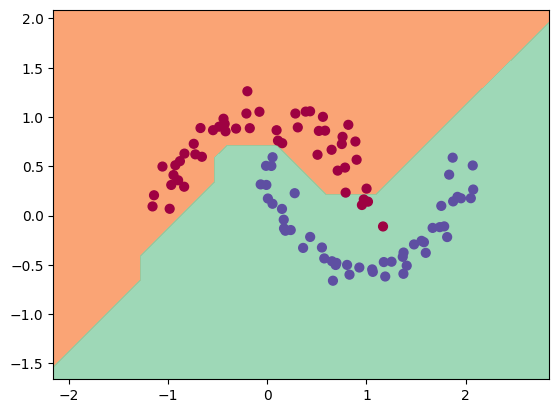

In [491]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
